In [1]:
from importlib import reload
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from tqdm.notebook import tqdm

## Loading git data

In [2]:
path = 'data/full_pkls/'
files = os.listdir(path)
len(files)

15

In [3]:
print(files[10])
stats = pickle.load(open(path + files[10], 'rb'))

tensorflow-tensorboard.pkl


### making users activity signals

In [4]:
from social_phi import get_signal, sliding_window, get_single_signal

sig = get_signal(stats['activities'], time_scale=24*3600, binarize=True)
sig.shape

(238, 2052)

### making signal for metrics

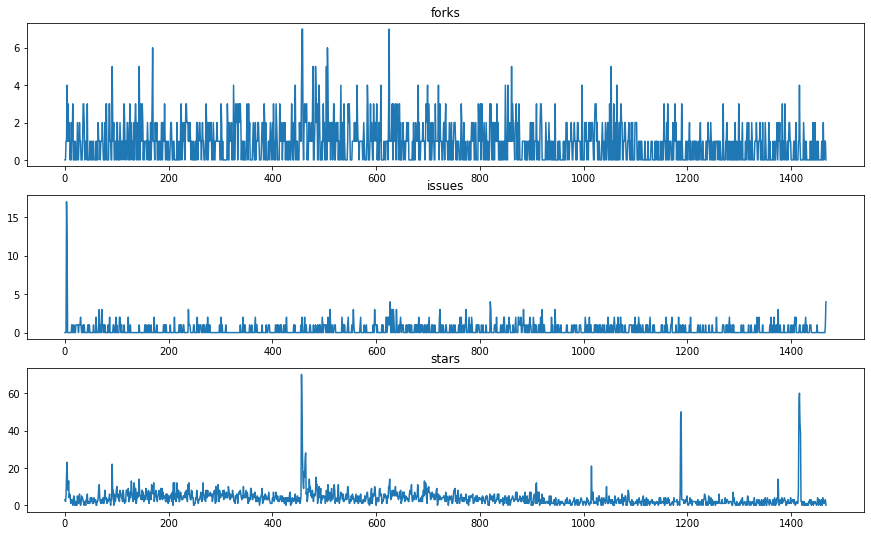

In [5]:
metrics = []
for k in ['forks', 'issues', 'stars']:
    metric, a, b = get_single_signal(stats[k], time_scale=24*3600, binarize=False)
    metrics += [{
        'sig': metric,
        'm' : b,
        'M' : a
    }]

m = min([metric['m'] for metric in metrics])
M = max([metric['M'] for metric in metrics])

metrics = np.stack([
    np.pad(metric['sig'], pad_width=(metric['m'] - m, M - metric['M'])) for metric in metrics
])

titles = ['forks', 'issues', 'stars']
plt.figure(figsize=(15, 3*len(metrics)))
for i,metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    plt.title(titles[i])
    plt.plot(metric)

plt.show()

(3, 84) (118,)


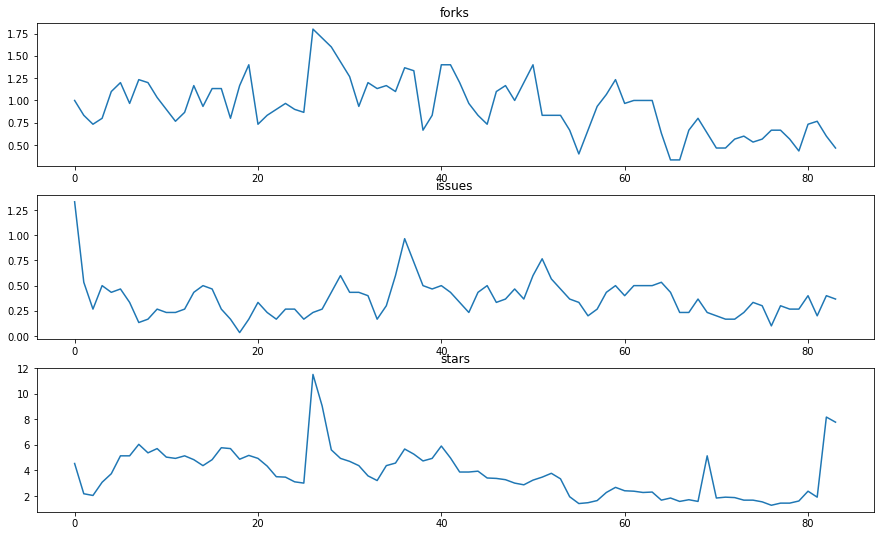

In [24]:
metrics_windowed = sliding_window(metrics, agg_func=np.mean, window=30, hop=17)
num_act = sliding_window(sig.sum(axis=0).reshape(1,-1), agg_func=np.mean, window=30, hop=17)[0]
print(metrics_windowed.shape, num_act.shape)


plt.figure(figsize=(15, 3*len(metrics_windowed)))
for i,metric in enumerate(metrics_windowed):
    plt.subplot(len(metrics_windowed), 1, i+1)
    plt.title(titles[i])
    plt.plot(metric)
plt.show()

## temporal phi

In [8]:
import social_phi
from social_phi import experiment_hop_range

stats = experiment_hop_range(sig=sig, window=30, min_hop=1, max_hop=30, silent=False)

In [22]:
np.argmax(stats['vnr'])

16

In [23]:
from social_phi import phi_for_act_sig

phis, phis_orig, n_users = phi_for_act_sig(sig, window=30, hop=17, base=2)
len(phis)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/social_phi/phi.py:13: RuntimeWarning: invalid value encountered in double_scalars
  prod = lambda x: x[0]*x[1]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/social_phi/phi.py:23: RuntimeWarning: divide by zero encountered in log
  term2 = 0.5*np.sum([np.log(s_m1) - np.log(s_part_m1_m2) for s_m1, s_part_m1_m2 in zip(S_M1, S_part_M1_M2)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/social_phi/phi.py:23: RuntimeWarning: invalid value encountered in double_scalars
  term2 = 0.5*np.sum([np.log(s_m1) - np.log(s_part_m1_m2) for s_m1, s_part_m1_m2 in zip(S_M1, S_part_M1_M2)])


118

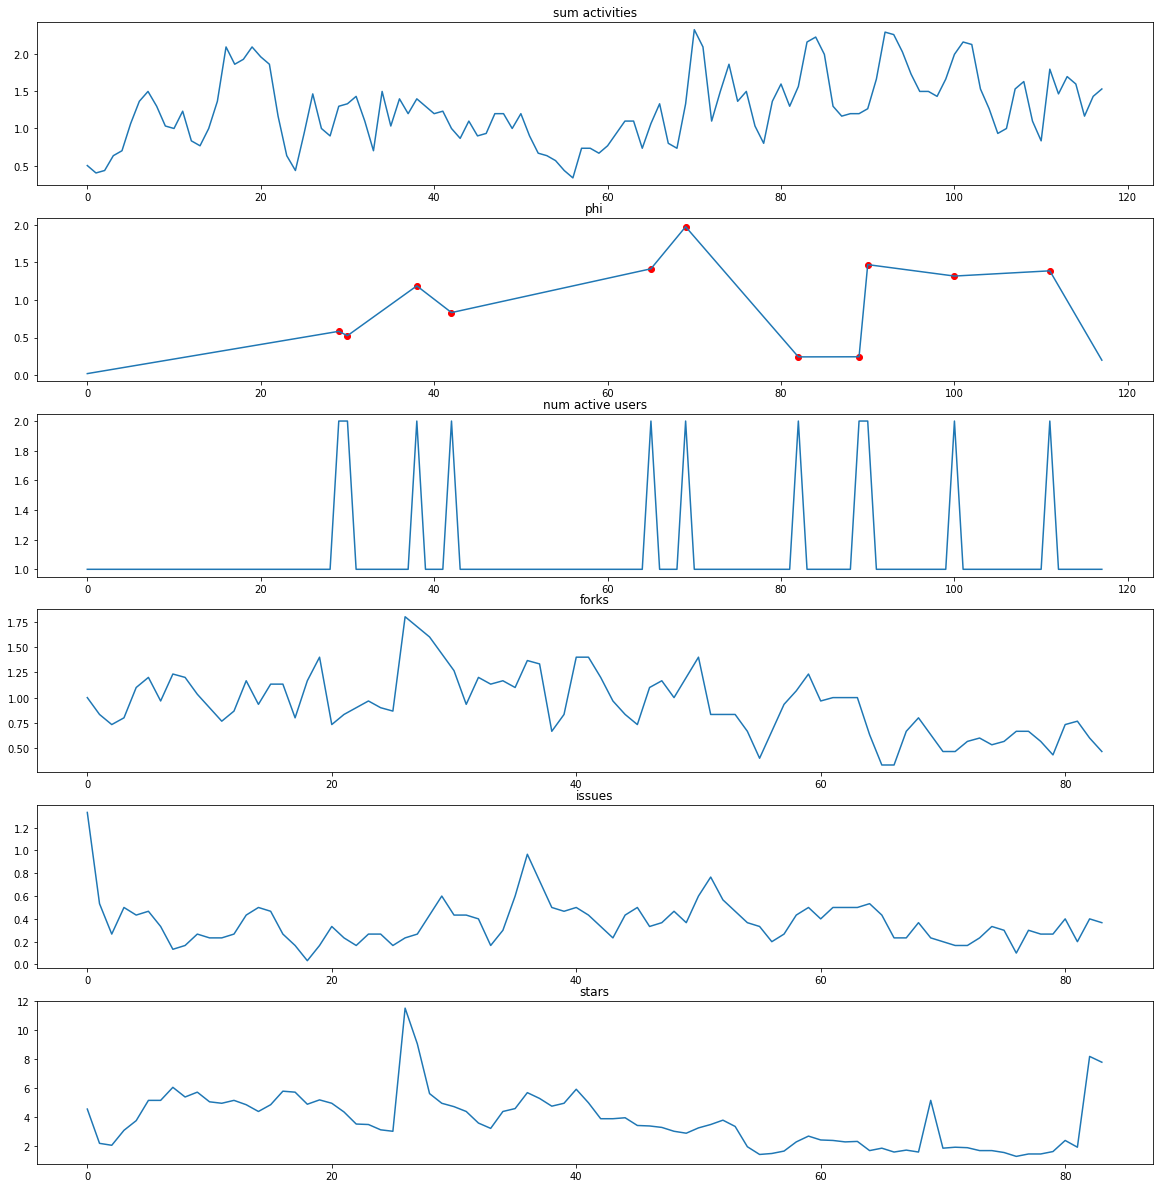

In [25]:
plt.figure(figsize=(20,21))

plt.subplot(3 + len(metrics_windowed),1,1)
plt.title('sum activities')
plt.plot(num_act)

plt.subplot(3+ len(metrics_windowed),1,2)
plt.title('phi')
data = np.array(list(enumerate(phis_orig)))
plt.scatter(x=data[:,0], y=data[:,1], c='red')
plt.plot(phis)

plt.subplot(3+ len(metrics_windowed),1,3)
plt.title('num active users')
plt.plot(n_users)

for i in range(len(metrics_windowed)):
    plt.subplot(3+ len(metrics_windowed),1,4+i)
    plt.title(titles[i])
    plt.plot(metrics_windowed[i])


plt.show()

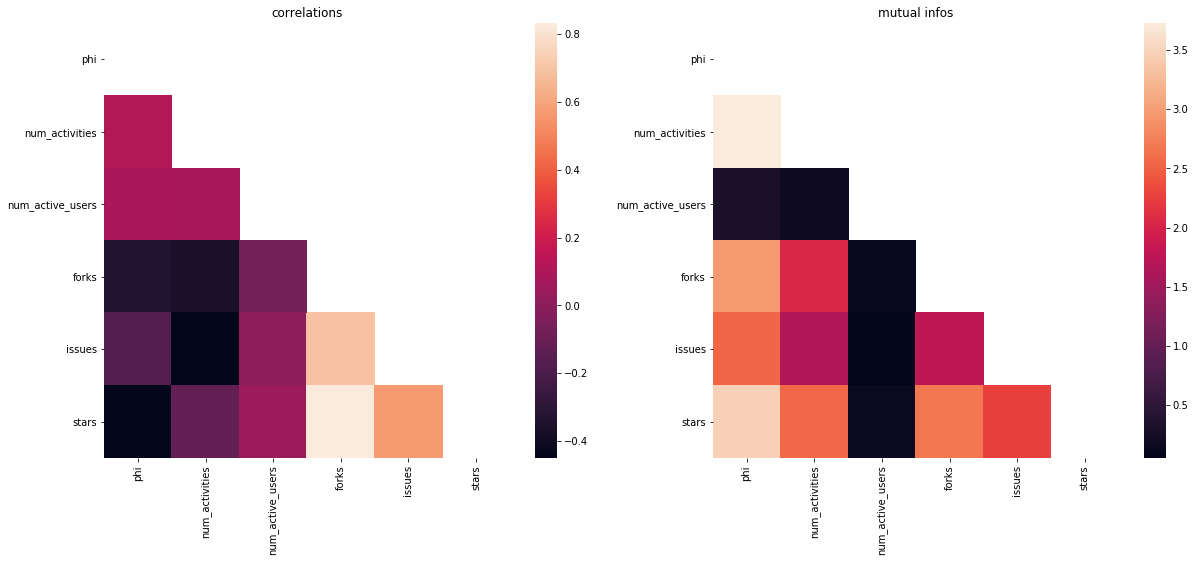

In [26]:
df = pd.DataFrame(columns=['phi', 'num_activities', 'num_active_users', 'forks', 'issues', 'stars'])

size = max(len(phis), metrics_windowed.shape[1])
df['phi'] = np.pad(phis, (0, size - len(phis)))
df['num_activities'] = np.pad(num_act, (0, size - len(num_act)))
df['num_active_users'] = np.pad(n_users, (0, size - len(n_users)))
df['forks'] = np.pad(metrics_windowed[0], (0, size - len(metrics_windowed[0])))
df['issues'] = np.pad(metrics_windowed[1], (0, size - len(metrics_windowed[1])))
df['stars'] = np.pad(metrics_windowed[2], (0, size - len(metrics_windowed[2])))

mis = np.zeros(shape=(6,6))
for i in range(6):
    for j in range(i):
        mis[i,j] = mutual_info_score(df[df.columns[i]], df[df.columns[j]])
        
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('correlations')
sns.heatmap(df.corr(), mask=np.triu(np.ones(6)))
plt.subplot(1,2,2)
plt.title('mutual infos')
sns.heatmap(pd.DataFrame(mis, index=df.columns, columns=df.columns), mask=np.triu(np.ones(6)))
plt.show()